# Iterate maps modeled in Pytorch Apple M1 (Metal) GPU


In [1]:
import math
import time
from types import SimpleNamespace
from tqdm import tqdm
import wandb

import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F

import matplotlib.pyplot as plt

import utils.iterated_map_utils as map_utils
import utils.ode_utils as ode_utils
import utils.torch_utils as torch_utils

## Lorentz attractor

In 1963, Edward Lorenz developed a simple mathematical model of the way air moves around in the atmosphere.
His model was a system of three ordinary differential equations that demonstrates deterministic chaos at certain parameter values and initial conditions. The Lorenz attractor is the system's strange attractor that resembles a butterfly when visualized.

The Lorenz system is nonlinear, three-dimensional, and deterministic. 

The Lorenz attractor is a set of chaotic solutions of the Lorenz system and is possibly the most famous depiction of a system that exibits chaotic behavior. Very slight changes to the initial conditions of the system lead to wildly different solutions. The system itself describes the movement of a point in a three-dimensional space over time using three ordinary differential equations that represent the movement of this point (x, y, z). In these equations, t represents time and sigma, rho, and beta are constant system parameters.

$$ \frac{dx}{dt} = \sigma (y - x) $$

$$ \frac{dy}{dt} = x (\rho - z) - y $$

$$ \frac{dz}{dt} = x y - \beta z $$

For his famous depiction of chaos, Lorenz used the values sigma = 10, beta = 8/3 and rho = 28. With these parameter values, the system exhibits deterministic chaos. It has a strange attractor with a fractal structure.

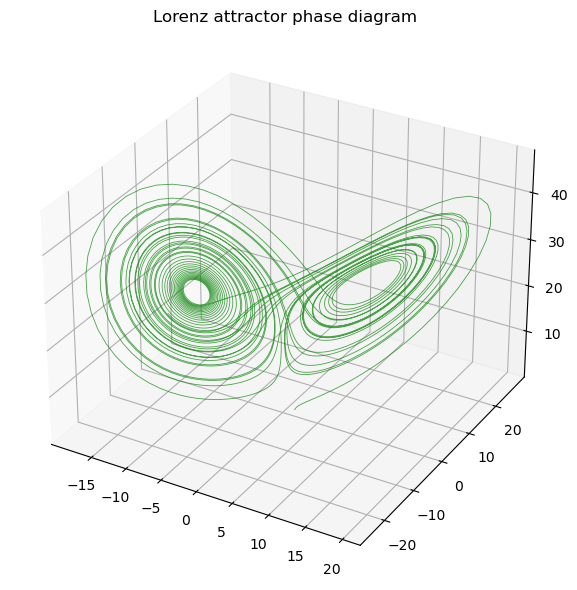

In [2]:
# parameters P and variable vector V
P = {'sigma': 10, 'beta': 8/3, 'rho': 28, 'dt': 0.01, 'n': 4000}
V = [1.5, 0.6, 0.7]
# trajectory T
T = ode_utils.iterate(ode_utils.lorentz_ode, V, **P)
# extract the individual arrays of x, y, and z values from the array of arrays
x, y, z = tuple(T.T)

# plot the lorenz attractor in three-dimensional phase space
fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot(projection='3d')
ax.plot(x, y, z, color='g', alpha=0.7, linewidth=0.6)
ax.set_title('Lorenz attractor phase diagram')
# fig.savefig('{}/lorenz-attractor-3d.png'.format(save_folder), dpi=180, bbox_inches='tight')
plt.tight_layout()
# plt.show()

## Model and train



In [3]:
class Model3N3(nn.Module):

    def name(self):
        return self._get_name()

    def __init__(self, num_hidden_units):
        super(Model3N3, self).__init__()

        self.fc1 = nn.Linear(3, num_hidden_units, bias=True)
        # self.fc2 = nn.Linear(num_hidden_units, num_hidden_units)
        self.fc3 = nn.Linear(num_hidden_units, 3, bias=True)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        # x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


def train(config, device):
    start = time.time()
    torch_utils.reset_seed(config.seed)

    # create mesh train data (x, y, z)
    # n_steps = int(config.num_samples**(1./3.))
    # x = np.linspace(-30., 30., n_steps)
    # y = np.linspace(-30., 30., n_steps)
    # z = np.linspace(0., 50., n_steps)
    # # create 3D meshgrid of x, y, z
    # X_train = np.vstack(np.meshgrid(x,y,z)).reshape(-1,3)

    # create random distributed train dataset
    mu, sigma = 0, 30 # mean and standard deviation
    x = np.random.normal(mu, sigma, config.num_samples)
    y = np.random.normal(mu, sigma, config.num_samples)
    mu, sigma = 25, 25 # mean and standard deviation
    z = np.random.normal(mu, sigma, config.num_samples)

    X_train = np.vstack((x,y,z)).T.reshape(-1,3)
    # shuffle
    # np.take(X_train, np.random.rand(X_train.shape[0]).argsort(), axis=0, out=X_train)

    # get the target values Y
    Y_train = ode_utils.rk4(ode_utils.lorentz_ode, X_train, t=1.0, **config.parameters)

    # put X and Y in dataset, suited for Apple M1 GPU (Mps)
    train_dataset = torch_utils.MpsDataset(X_train, Y_train, device)
    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=config.batch_size, shuffle=True)

    # init model
    model = Model3N3(config.num_hidden_units)
    model.to(config.device)

    # Make the loss and optimizer
    # loss_fn = torch.nn.MSELoss(reduction='sum')
    loss_fn = torch.nn.MSELoss(reduction='mean')

    if hasattr(config, 'weight_decay'):
        optimizer = torch.optim.Adam(params=model.parameters(), lr=config.learning_rate, weight_decay=config.weight_decay)
    else:
        optimizer = torch.optim.Adam(params=model.parameters(), lr=config.learning_rate)

    train_loss=[]
    train_accuray=[]

    example_ct = 0
    for epoch in range(config.epochs):
        with tqdm(train_loader, unit=" batch") as tepoch:
            for step, (X, Y) in enumerate(tepoch):
                tepoch.set_description(f"Epoch {epoch+1}/{config.epochs}")
                
                X, Y = X.to(device=config.device), Y.to(device=config.device)
                optimizer.zero_grad()
                Y_hat = model(X)
                # loss = loss_fn(Y_hat, Y)
                loss = torch.sqrt(loss_fn(Y_hat, Y))
                loss.backward()
                optimizer.step()

                correct = (abs(Y_hat - Y)<0.01).sum().item()
                accuracy = correct / config.batch_size

                example_ct += len(Y)
                tepoch.set_postfix(loss=loss.item(), accuracy=100.*accuracy, examples=f'{round(example_ct/1000, 0)}K')

                wandb.log({"loss": loss})
                train_loss.append(loss.item())
                wandb.log({"accuracy": accuracy})
                train_accuray.append(accuracy)

    # calculate timesteps for the ODE trajectory
    n_steps_per_epoch = math.ceil(len(train_loader.dataset) / config.batch_size)
    epoch_time = [x/n_steps_per_epoch for x in range(len(train_loss))]

    end = time.time()
    print(f'training time: {end - start: .2f} sec')

    return model, epoch_time, train_loss, train_accuray
    

## Config

In [14]:
config = SimpleNamespace(
    # reproducability
    seed=33,
    
    # train model
    num_experiments=1,
    model_name="Model3N3",
    num_hidden_units=9,

    # train regime
    batch_size=64,  # 32 better than 64 better than 128
    epochs=7,

    # train data
    dataset="lorentz ode",
    map_name="lorentz_ode",
    parameters = {'sigma': 10, 'beta': 8/3, 'rho': 28, 'dt': 0.01},
    num_samples = 20**3,  # 30**3 better than 40**3
    
    optimizer="Adam",
    learning_rate=2e-3,  # 2e-2
    # weight_decay=1e-2,  # 1e-2

    # device
    device="mps",
    dtype="float32",
    num_workers=4,
    gpu_name="M1Pro GPU 16 Cores",
    mixed_precision=False,
    channels_last=False,
)

wandb.init(project="iterate-lorentz-torch-metal", config=config)
# wandb.config = vars(config)
wandb.config = config

device  = torch_utils.get_device()
model, epoch_time, train_loss, train_accuracy = train(config, device)

accuracy,▁▁▁▁▁▁▁▁▃▃▁▁▁▃▁▃▁▁▃▃▁▁▁▁▁▆▁▁▁█▁▆▁▁▁▁▁▃▃█
loss,██▆▅▃▂▂▂▁▂▁▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
accuracy,0.0
loss,1.81313


pytorch using device: mps


Epoch 7/7: 100%|██████████| 125/125 [00:05<00:00, 21.89 batch/s, accuracy=1.56, examples=56.0K, loss=2.21]

training time:  39.33 sec


## Visualize loss

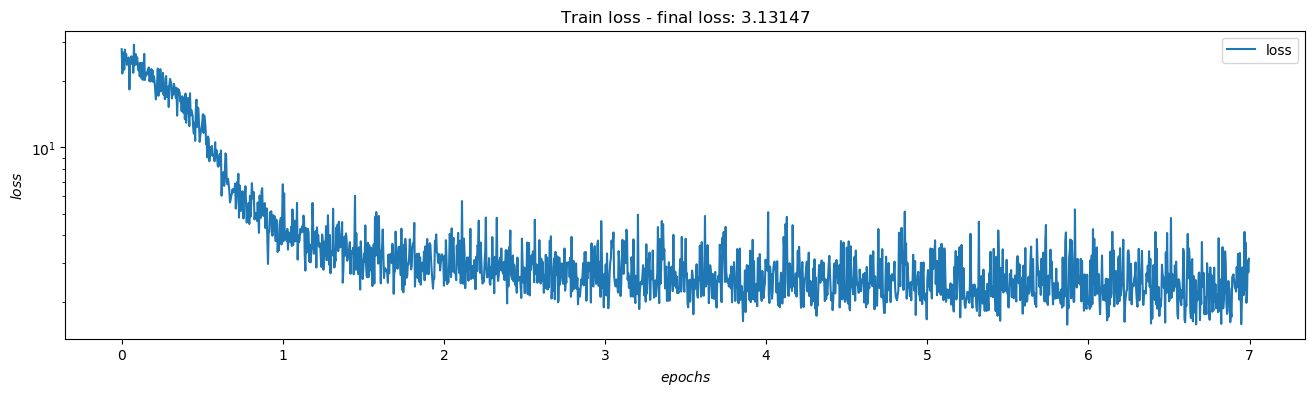

In [5]:
fig, ax = plt.subplots(1, 1, figsize=(16, 4))
ax.plot(epoch_time, train_loss, label='loss')
# ax.plot(epoch_time, train_accuracy, label='accuracy')
ax.set_title(f'Train loss - final loss: ${train_loss[-1]: .5f}$')
ax.set_xlabel('$epochs$')
ax.set_ylabel('$loss$')
ax.set_yscale('log')
ax.legend(loc="upper right")
plt.show()

## Visualize actual vs predicted

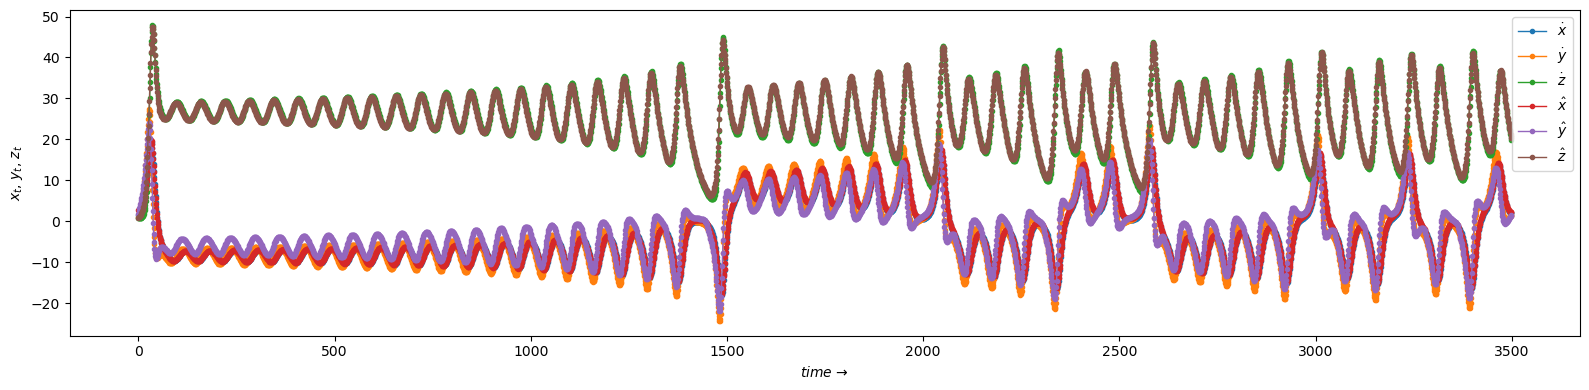

In [6]:
P = config.parameters
x0 = [1.5, 0.6, 0.7]

X = ode_utils.iterate(ode_utils.lorentz_ode, x0, n=3501, **P)
Y_dot = X[1:,:]
X = X[:-1,:]

X_torch = torch.tensor(X, dtype=torch.float32).to(config.device)
Y_hat = model(X_torch)
Y_hat = Y_hat.cpu().detach().numpy()

fig, ax1 = plt.subplots(1, 1, figsize=(16, 4))  #, gridspec_kw={'width_ratios': [3, 1]}, sharey=True)

ax1.plot(Y_dot, marker='.', lw=1, label=['$\dot{x}$', '$\dot{y}$', '$\dot{z}$'])
ax1.plot(Y_hat, marker='.', lw=1, label=['$\hat{x}$', '$\hat{y}$', '$\hat{z}$'])

ax1.set_xlabel(f'$time$ $→$')
ax1.set_ylabel(f'$x_t$, $y_t$, $z_t$')
# ax1.legend(loc="upper left")
ax1.legend()

plt.tight_layout()

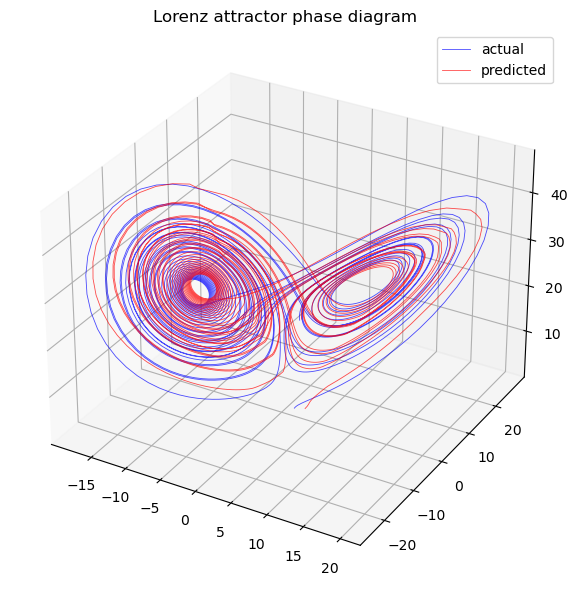

In [7]:
x_dot, y_dot, z_dot = tuple(Y_dot.T)
x_hat, y_hat, z_hat = tuple(Y_hat.T)

# plot the lorenz attractor in three-dimensional phase space
fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot(projection='3d')
ax.plot(x_dot, y_dot, z_dot, color='b', alpha=0.7, linewidth=0.6, label='actual')
ax.plot(x_hat, y_hat, z_hat, color='r', alpha=0.7, linewidth=0.6, label='predicted')
ax.set_title('Lorenz attractor phase diagram')
ax.legend()

# fig.savefig('{}/lorenz-attractor-3d.png'.format(save_folder), dpi=180, bbox_inches='tight')
plt.tight_layout()

## In progress - reading model parameters

In [8]:
model_parameters = filter(lambda p: p.requires_grad, model.parameters())
num_params = sum([np.prod(p.size()) for p in model_parameters])
print(model)
print(f'num_params: {num_params}')

Model3N3(
  (fc1): Linear(in_features=3, out_features=8, bias=True)
  (fc3): Linear(in_features=8, out_features=3, bias=True)
)
num_params: 59


In [9]:
for param in model.parameters():
    if param.requires_grad:
        print(param)

print('\n')

for name, param in model.named_parameters():
    if param.requires_grad:
        print(f'{name}: {param.cpu().detach().numpy().flatten()}')

Parameter containing:
tensor([[ 0.4244,  0.3408, -0.4851],
        [-0.7358, -0.6989, -0.3547],
        [ 0.8635, -0.4632,  0.7227],
        [-0.5111, -0.4775,  0.4358],
        [-0.8142,  0.6078, -0.5749],
        [-0.8043,  0.3724,  0.6373],
        [ 0.7724, -0.4598, -0.5602],
        [ 0.6064,  0.5931,  0.1901]], device='mps:0', requires_grad=True)
Parameter containing:
tensor([1.5869, 2.1265, 0.5238, 0.4605, 0.8733, 0.3887, 1.0471, 1.3529],
       device='mps:0', requires_grad=True)
Parameter containing:
tensor([[ 0.1073, -0.4706,  0.2133, -0.0815, -0.2383, -0.3827,  0.4071,  0.5681],
        [ 0.4278, -0.8725, -0.5726, -0.0448,  0.1905,  0.3987, -0.0415,  0.8502],
        [ 0.0021,  0.0283,  0.4549,  0.3763, -0.7397,  0.5477, -0.8302,  0.4796]],
       device='mps:0', requires_grad=True)
Parameter containing:
tensor([-0.0097,  0.0537, -0.2431], device='mps:0', requires_grad=True)


fc1.weight: [ 0.42443505  0.34082878 -0.48509622 -0.7357628  -0.69891095 -0.35470533
  0.8635174  -

/opt/miniconda3/envs/torch-metal/lib/python3.9/site-packages/torch/_tensor_str.py:103: UserWarning: The operator 'aten::bitwise_and.Tensor_out' is not currently supported on the MPS backend and will fall back to run on the CPU. This may have performance implications. (Triggered internally at  /Users/runner/miniforge3/conda-bld/pytorch-recipe_1664817727684/work/aten/src/ATen/mps/MPSFallback.mm:11.)
  nonzero_finite_vals = torch.masked_select(tensor_view, torch.isfinite(tensor_view) & tensor_view.ne(0))
